# Tabular_Pancreas + Baron


In [1]:
import os
import glob
import sys
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns

sys.path.append('../')
import src.utils as my_u
from src.utils import df_cp
from src.utils import df_log
from src.utils import df_total20000
from src.utils import df_minmax
from src.utils import df_l2norm
from src.utils import df_zscore
from src.utils import df_meansquare
from src.utils import run_plot


file_list = glob.glob("../dataset/baron/RAW/*mouse*counts.csv")
print(file_list)

['../dataset/baron/RAW/GSM2230761_mouse1_umifm_counts.csv', '../dataset/baron/RAW/GSM2230762_mouse2_umifm_counts.csv']


In [2]:
total_data = pd.DataFrame()
for ff in file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    total_data = total_data.append(data)
    print(total_data.shape)

labels = total_data['assigned_cluster'].values.tolist()
label_set = set(labels)
print(label_set)

total_data = total_data.iloc[:,2:]

(822, 14880)
(1886, 14880)
{'B_cell', 'T_cell', 'immune_other', 'quiescent_stellate', 'gamma', 'endothelial', 'beta', 'activated_stellate', 'delta', 'alpha', 'schwann', 'macrophage', 'ductal'}


In [3]:
baron_labels = labels
baron_total_data = total_data

# Tabula Pancreas

In [4]:
file_list = glob.glob("../data/tabular_muris/00_facs_raw_data/FACS/Pancreas-counts.csv")
sample_per_class = 200

labels = []
total_data = pd.DataFrame()
for ff in file_list:
    data = pd.read_csv(ff, sep=',', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    total_data = pd.concat([total_data, data.iloc[c,]], axis=0)
    labels += [ff.split('/')[-1].rstrip('-counts.csv')] * sample_per_class #data.shape[0]

label_set = set(labels)
print(label_set)


annot_label = pd.read_csv('../data/tabular_muris/00_facs_raw_data/annotations_FACS.csv', sep=',', index_col=0, header=0)

com = annot_label['tissue'].index.intersection(total_data.index)
m = annot_label.filter(com, axis=0)

total_data = total_data.filter(com, axis=0)
total_data = pd.concat([total_data, m['cell_ontology_class']],axis =1)


tissue = labels
labels = total_data['cell_ontology_class']
labels = labels.values.tolist()

total_data.pop('cell_ontology_class')
total_data.pop('zsGreen_transgene')
print(set(labels))

{'Pancrea'}
{'pancreatic ductal cell', 'pancreatic stellate cell', 'pancreatic acinar cell', 'pancreatic PP cell', 'pancreatic D cell', 'pancreatic A cell', 'type B pancreatic cell', 'leukocyte', 'endothelial cell'}


In [5]:
tabula_data = total_data
tabula_labels = labels

In [6]:
new_lab = []
for x in tabula_labels:
    try:
        x=x.replace('pancreatic A cell', 'alpha')
    except:
        pass
    try:
        x=x.replace('endothelial cell', 'endothelial')
    except:
        pass
    try:
        x=x.replace('pancreatic D cell', 'delta')
    except:
        pass
    try:
        x=x.replace('pancreatic acinar cell', 'acinar')
    except:
        pass
    try:
        x=x.replace('pancreatic ductal cell', 'ductal')
    except:
        pass
    try:
        x=x.replace('type B pancreatic cell', 'beta')
    except:
        pass
    try:
        x=x.replace('pancreatic stellate cell', 'stellate')
    except:
        pass
    try:
        x=x.replace('pancreatic PP cell', 'PP')
    except:
        pass
    try:
        x=x.replace('activated_stellate', 'stellate')
    except:
        pass
    try:
        x=x.replace('quiescent_stellate', 'stellate')
    except:
        pass
    new_lab.append(x)
tabula_labels = new_lab
print(set(tabula_labels))

{'endothelial', 'beta', 'acinar', 'PP', 'delta', 'alpha', 'leukocyte', 'stellate', 'ductal'}


# MCA

In [7]:
common_mca_files = glob.glob("../dataset/MCA/mousecellatlas/*_Pancreas_*.txt")
print((common_mca_files))

['../dataset/MCA/mousecellatlas/GSM2906458_Pancreas_dge.txt']


In [8]:
# MCA data load
#sample_per_class = 500

mca_labels = []
mca_tabula_labels = []
mca_data = pd.DataFrame()
for ff in common_mca_files:
    data = pd.read_csv(ff, sep='\s+', index_col=0, header=0)
    data = data.transpose()
    c = list(range(data.shape[0]))
    data = data.iloc[c,]
    mca_data = pd.concat([mca_data, data], axis=0)
    print(mca_data.shape, ff)
    mca_labels += [ff.rstrip('_dge.txt').split('/')[-1].split('_')[1]] * data.shape[0]

mca_data.replace(np.nan,0)
mca_label_set = set(mca_labels)
print(mca_label_set)


(4405, 20283) ../dataset/MCA/mousecellatlas/GSM2906458_Pancreas_dge.txt
{'Pancreas'}


In [9]:
m = pd.read_csv("../dataset/MCA/mousecellatlas/MCA_CellAssignments.csv", sep=',', index_col=1, header=0)

#print(m)
#m = m.replace(np.nan, 'nan')
#m = m.loc[m['Annotation'] != 'nan',]
print(m.shape)
m = m.loc[m['Annotation'] != 'Dividing cell(Pancreas)',]
m = m.loc[m['Annotation'] != 'Erythroblast_Igkc high(Pancreas)',]
m = m.loc[m['Annotation'] != 'Erythroblast_Hbb-bt high(Pancreas)',]
m = m.loc[m['Annotation'] != 'Stromal cell_Fn1 high(Pancreas)',]
m = m.loc[m['Annotation'] != 'Stromal cell_Smoc2 high(Pancreas)',]
m = m.loc[m['Annotation'] != 'Stromal cell_Mfap4 high(Pancreas)',]
m = m.loc[m['Annotation'] != 'Smooth muscle cell_Acta2 high(Pancreas)',]
m = m.loc[m['Annotation'] != 'Smooth muscle cell_Rgs5 high(Pancreas)',]

print(m.shape)

com = m['Annotation'].index.intersection(mca_data.index)
m = m.filter(com, axis=0)
mca_data = mca_data.filter(com, axis=0)
print(m.shape)


mca_data = pd.concat([mca_data, m[['Tissue','Annotation']]],axis =1)

mca_tissue = mca_data['Tissue']
mca_labels = mca_data['Annotation']
mca_tissue = mca_tissue.values.tolist()
mca_labels = mca_labels.values.tolist()

mca_data.pop('Tissue')
mca_data.pop('Annotation')
print(set(list(mca_labels)))
print(set(mca_tissue))


(270848, 6)
(269196, 6)
(1958, 6)
{'Macrophage(Pancreas)', 'Dendrtic cell(Pancreas)', 'Macrophage_Ly6c2 high(Pancreas)', 'Endocrine cell(Pancreas)', 'Granulocyte(Pancreas)', 'Acinar cell(Pancreas)', 'Endothelial cell_Lrg1 high(Pancreas)', 'B cell(Pancreas)', 'Ductal cell(Pancreas)', 'Glial cell(Pancreas)', 'Endothelial cell_Tm4sf1 high(Pancreas)', 'T cell(Pancreas)', 'β-cell(Pancreas)', 'Endothelial cell_Fabp4 high(Pancreas)'}
{'Pancreas'}


In [10]:
mca_labels = [x.split('_')[0].split('(')[0] for x in mca_labels]
mca_data.shape
print(set(mca_labels))

{'Glial cell', 'Acinar cell', 'Granulocyte', 'Endothelial cell', 'Ductal cell', 'Endocrine cell', 'B cell', 'Dendrtic cell', 'Macrophage', 'T cell', 'β-cell'}


In [11]:
common_gene = baron_total_data.columns.intersection(tabula_data.columns)
common_gene = common_gene.intersection(mca_data.columns)

tabula_data = tabula_data.filter(common_gene)
baron_total_data = baron_total_data.filter(common_gene)
mca_data = mca_data.filter(common_gene)

total_data = pd.concat([tabula_data,baron_total_data, mca_data], axis=0)
labels =  tabula_labels + baron_labels  + mca_labels
blabels = ['tabula']*len(tabula_labels) + ['baron']*len(baron_labels) + ['MCA'] * len(mca_labels)
total_data.shape
print(total_data.shape)
print(set(labels))
print(set(blabels))

(5171, 12584)
{'T_cell', 'gamma', 'endothelial', 'activated_stellate', 'PP', 'T cell', 'schwann', 'stellate', 'Glial cell', 'Acinar cell', 'beta', 'Macrophage', 'Granulocyte', 'quiescent_stellate', 'Endothelial cell', 'acinar', 'Ductal cell', 'B cell', 'ductal', 'B_cell', 'immune_other', 'Endocrine cell', 'delta', 'alpha', 'leukocyte', 'Dendrtic cell', 'β-cell', 'macrophage'}
{'baron', 'tabula', 'MCA'}


In [12]:
new_lab2 = []
for x in labels:
    try:
        x=x.replace('Endothelial cell', 'endothelial')
    except:
        continue
    try:
        x=x.replace('Glial cell', 'i_Glial')
    except:
        continue
    try:
        x=x.replace('Granulocyte', 'i_Granulocyte')
    except:
        continue
    try:
        x=x.replace('Dendrtic cell', 'i_dendrtic_cell')
    except:
        continue
    try:
        x=x.replace('Ductal cell', 'ductal')
    except:
        continue
    try:
        x=x.replace('Acinar cell', 'acinar')
    except:
        continue
    try:
        x=x.replace('β-cell', 'beta')
    except:
        continue
    try:
        x=x.replace('B cell', 'i_b_cell')
    except:
        continue
    try:
        x=x.replace('B_cell', 'i_b_cell')
    except:
        continue
    try:
        x=x.replace('T cell', 'i_t_cell')
    except:
        continue
    try:
        x=x.replace('T_cell', 'i_t_cell')
    except:
        continue
    try:
        x=x.replace('gamma', 'i_gamma')
    except:
        continue
    try:
        x=x.replace('Myeloid progenitor cell', 'i_Myeloid progenitor cell')
    except:
        continue
    try:
        x=x.replace('Monocyte', 'i_Monocyte')
    except:
        continue
    try:
        x=x.replace('NK cell', 'i_NK_cell')
    except:
        continue
    try:
        x=x.replace('leukocyte', 'i_leukocyte')
    except:
        continue
    try:
        x=x.replace('macrophage', 'i_macrophage')
    except:
        continue
    try:
        x=x.replace('Macrophage', 'i_macrophage')
    except:
        continue
    try:
        x=x.replace('Dendritic cell', 'i_Dendritic cell')
    except:
        continue
    try:
        x=x.replace('activated_stellate', 'stellate')
    except:
        continue
    try:
        x=x.replace('quiescent_stellate', 'stellate')
    except:
        continue
    try:
        x=x.replace('pancreatic PP cell', 'e_PP_cell')
    except:
        continue
    new_lab2.append(x)
labels2 = new_lab2
print(set(labels2))

{'endothelial', 'i_t_cell', 'PP', 'i_macrophage', 'schwann', 'stellate', 'beta', 'i_leukocyte', 'i_dendrtic_cell', 'i_Glial', 'acinar', 'i_gamma', 'i_b_cell', 'ductal', 'immune_other', 'Endocrine cell', 'delta', 'alpha', 'i_Granulocyte'}


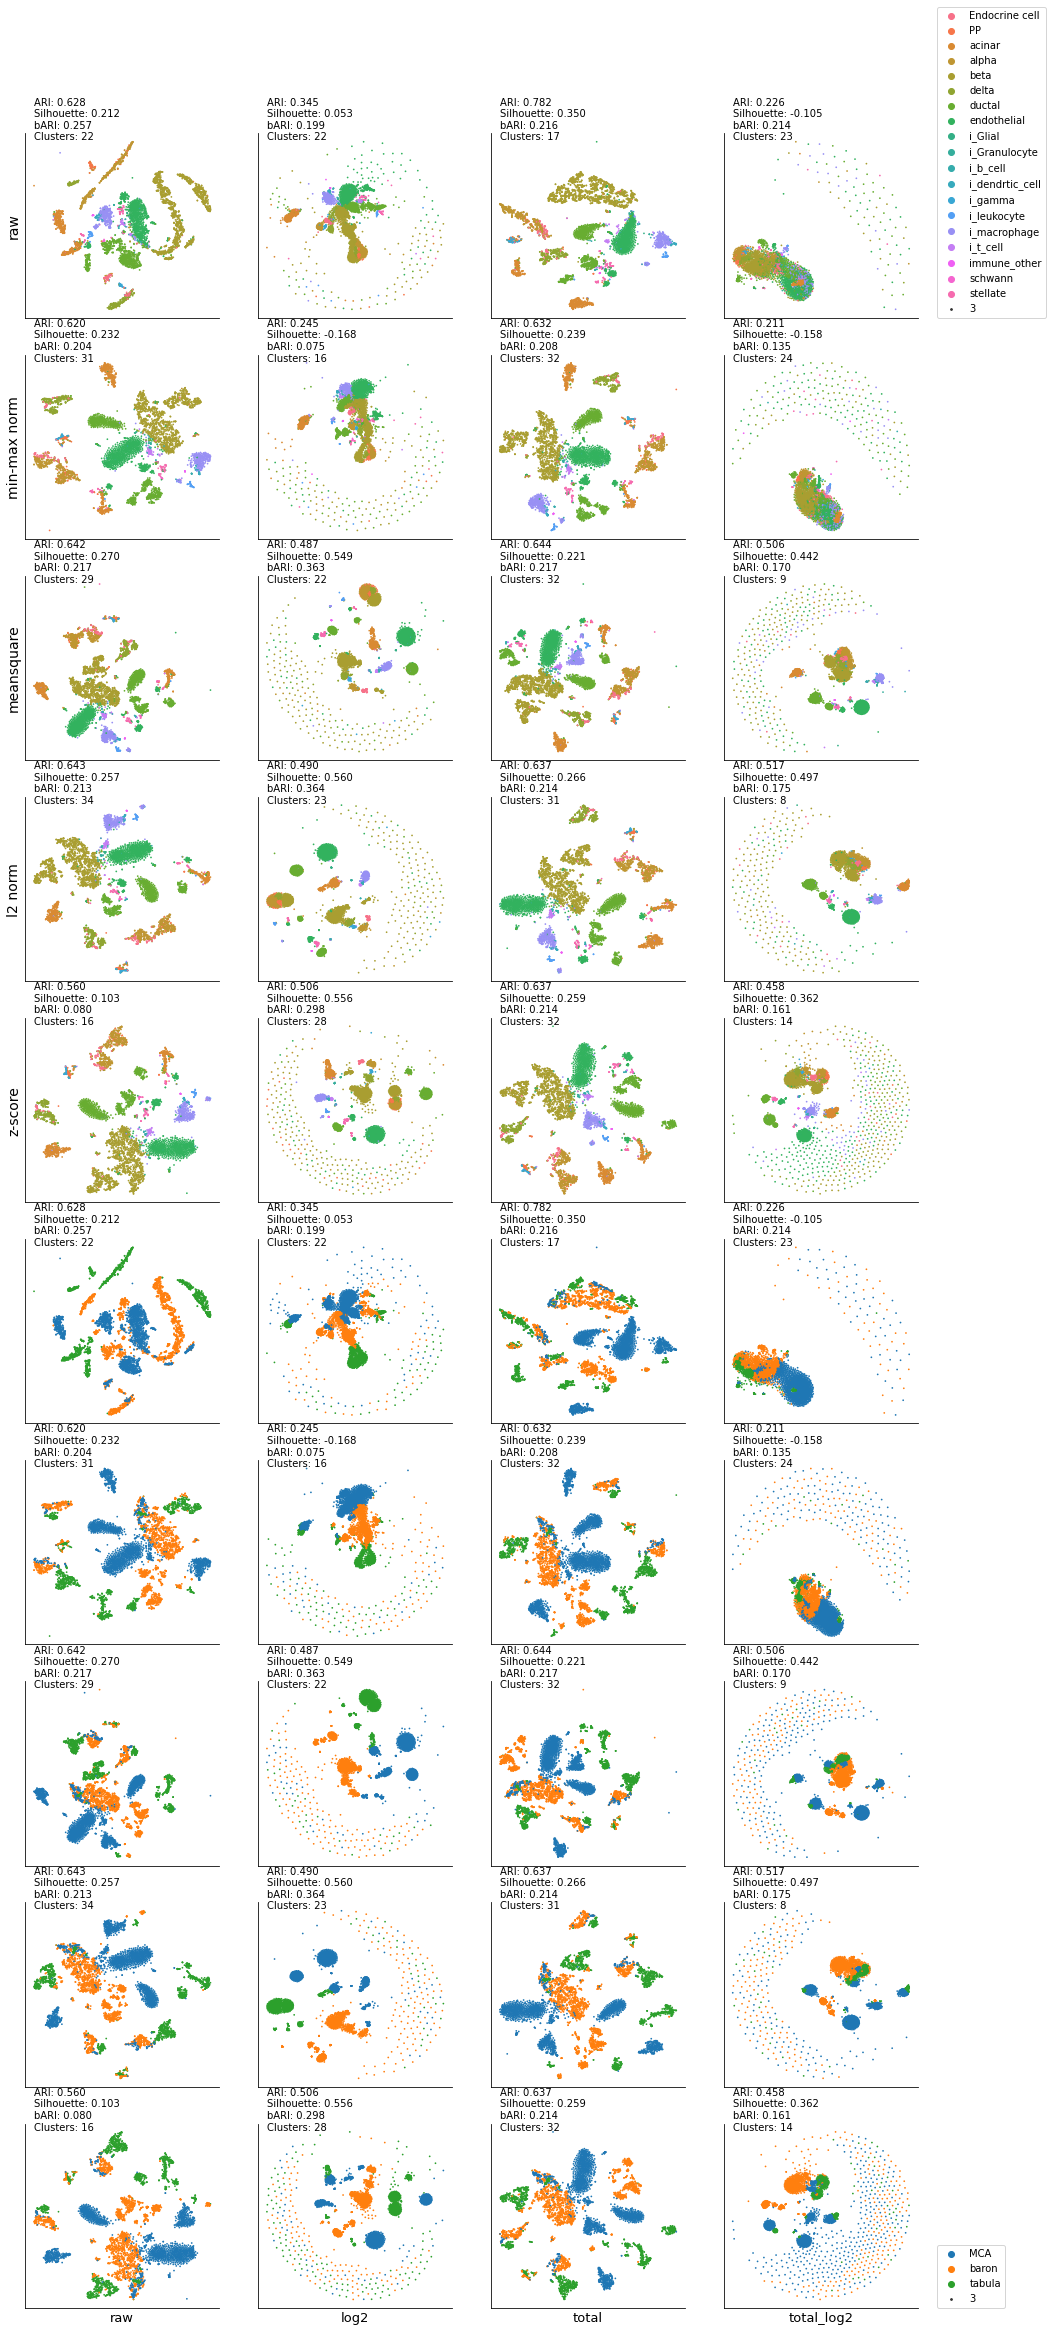

In [13]:
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_cp(total_data), \
         ax00, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )

############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = TSNE(n_components=2)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )

############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax30.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)

In [ ]:
rr = pd.DataFrame(l)
plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot()
ax.scatter(rr.loc[:,1],rr.loc[:,2], c=rr.index, cmap='rainbow',)
plt.xlim(0.0,1)
plt.ylim(0.0,0.62)
plt.xlabel('ARI')
plt.ylabel('Silhouette')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])

In [ ]:
rr = pd.DataFrame(l)
plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot()
ax.scatter(rr.loc[:,1],rr.loc[:,2], c=rr.index, cmap='rainbow',)
plt.xlim(0.0,1)
plt.ylim(0.0,0.62)
plt.xlabel('ARI')
plt.ylabel('Silhouette')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])
for i in range(20):
    #ax.annotate(str(i), (r.loc[i,1], r.loc[i,2]),xytext=(r.loc[i,2]-np.random.normal(0, 0.03), r.loc[i,2] -np.random.normal(0, 0.03)),arrowprops=dict(arrowstyle="->"))
    ax.annotate(str(i), (rr.loc[i,1], rr.loc[i,2]),xytext=(rr.loc[i,1]-np.random.normal(0, 0.05), rr.loc[i,2] -np.random.normal(0, 0.03)),arrowprops=dict(arrowstyle="->"))


In [ ]:
rr = pd.DataFrame(l)
plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot()
ax.scatter(rr.loc[:,1],1-rr.loc[:,3], c=rr.index, cmap='rainbow',)
plt.xlim(0.0,1)
plt.ylim(0.6,1)
plt.xlabel('ARI')
plt.ylabel('1-bARI')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])

In [ ]:
rr = pd.DataFrame(l)
plt.figure(figsize=(5,5), dpi=300)
ax = plt.subplot()
ax.scatter(rr.loc[:,1],1-rr.loc[:,3], c=rr.index, cmap='rainbow',)
plt.xlim(0.0,1)
plt.ylim(0.6,1)
plt.xlabel('ARI')
plt.ylabel('1-bARI')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.get_xaxis().set_ticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
#ax.get_yaxis().set_ticks([0.4,0.5,0.6,0.7])
for i in range(20):
    #ax.annotate(str(i), (r.loc[i,1], r.loc[i,3]),xytext=(r.loc[i,1]-np.random.normal(0, 0.03), 1-r.loc[i,3] -np.random.normal(0, 0.03)),arrowprops=dict(arrowstyle="->"))
    ax.annotate(str(i), (rr.loc[i,1], 1-rr.loc[i,3]),xytext=(rr.loc[i,1]-np.random.normal(0, 0.05), 1-rr.loc[i,3] -np.random.normal(0, 0.03)),arrowprops=dict(arrowstyle="->"))


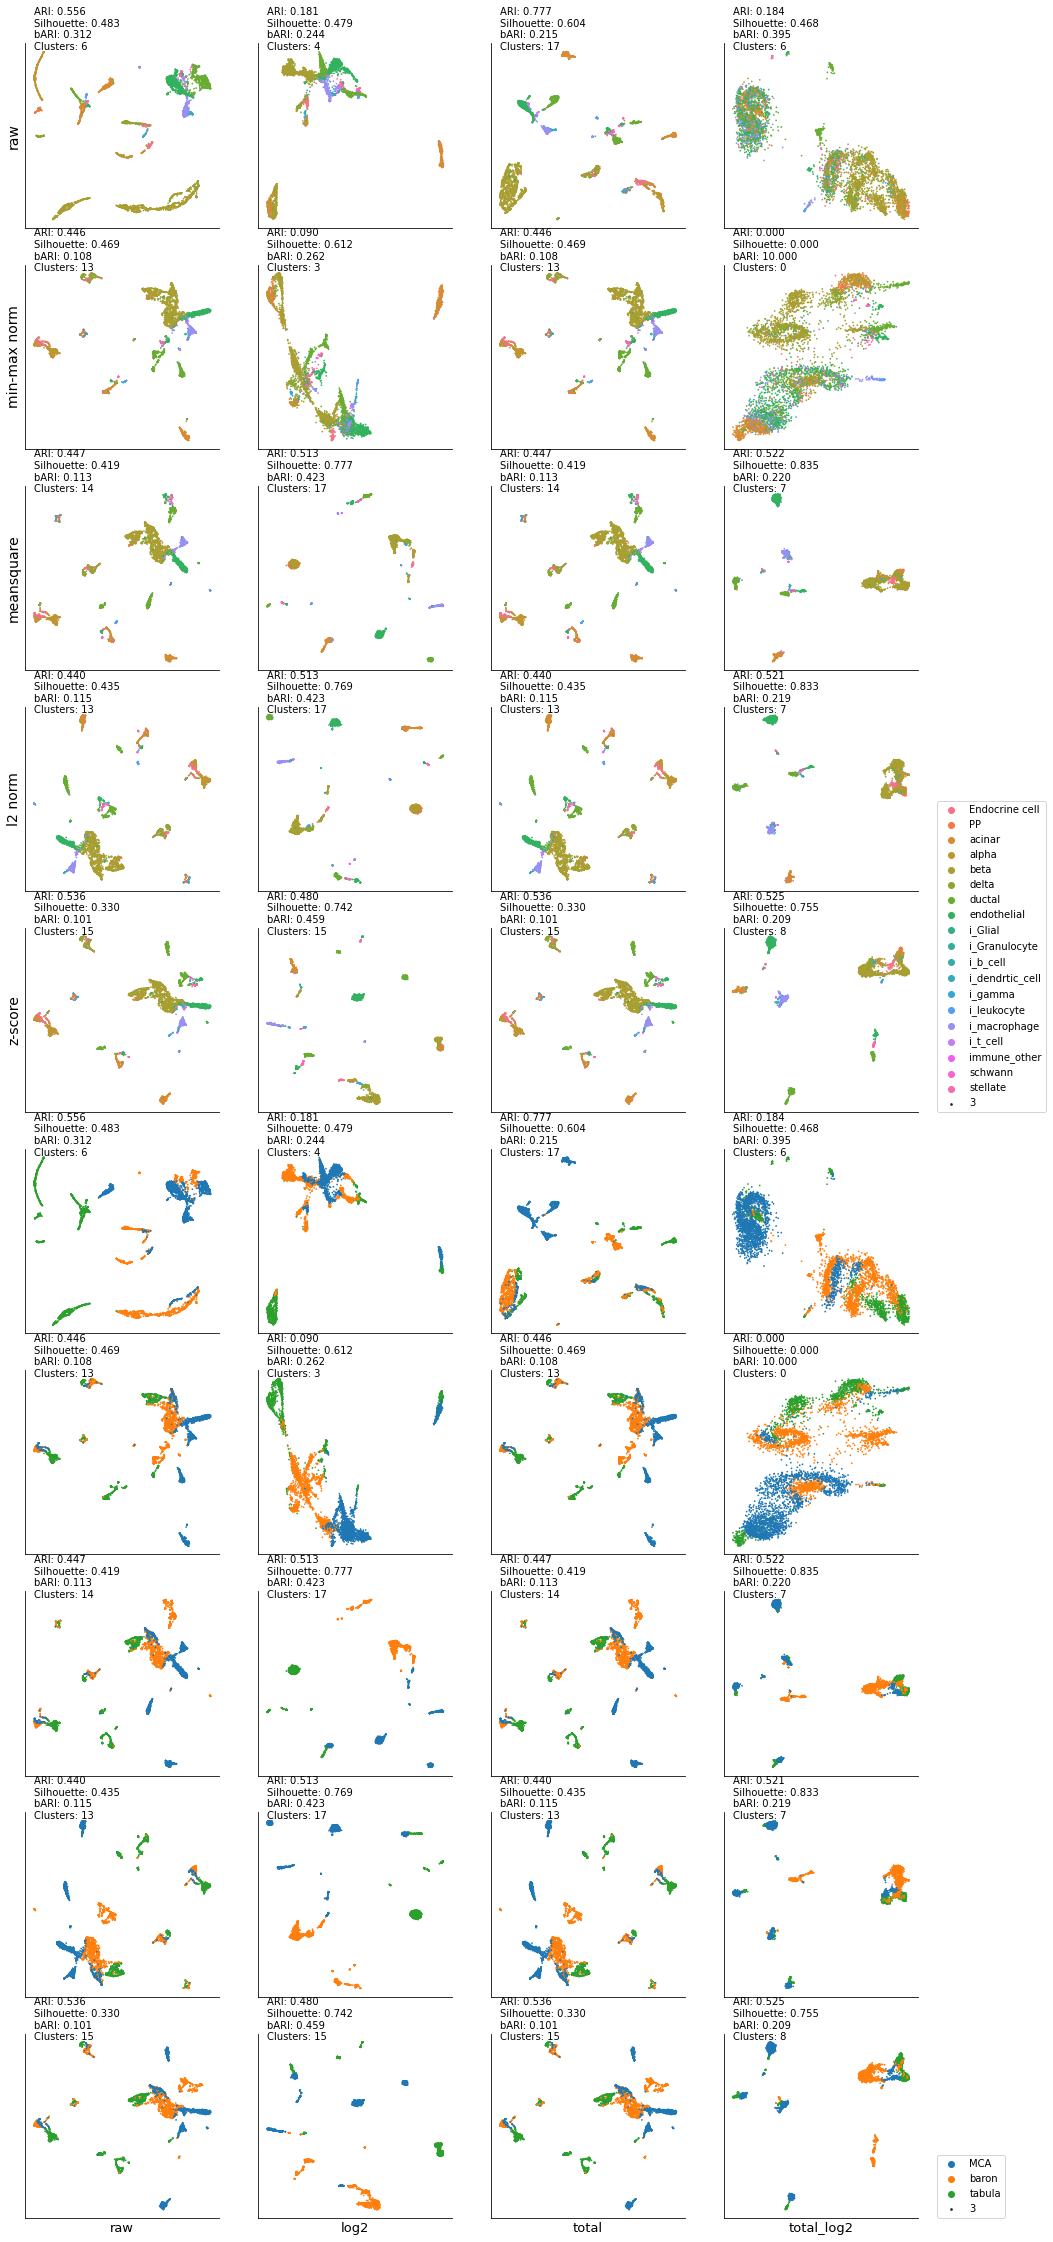

In [14]:
latent_space = TSNE(n_components=2)
#latent_space = UMAP(n_components=2, init='spectral', random_state=0)
clustering_method = 'dbscan'

############################################
plt.figure(figsize=(16,40))
ax00 = plt.subplot2grid((10,4), (0,0)) 
ax10 = plt.subplot2grid((10,4), (0,1))  
ax20 = plt.subplot2grid((10,4), (0,2))  
ax30 = plt.subplot2grid((10,4), (0,3))  

ax01 = plt.subplot2grid((10,4), (1,0)) 
ax11 = plt.subplot2grid((10,4), (1,1))  
ax21 = plt.subplot2grid((10,4), (1,2))  
ax31 = plt.subplot2grid((10,4), (1,3))  

ax02 = plt.subplot2grid((10,4), (2,0)) 
ax12 = plt.subplot2grid((10,4), (2,1))  
ax22 = plt.subplot2grid((10,4), (2,2))  
ax32 = plt.subplot2grid((10,4), (2,3))  

ax03 = plt.subplot2grid((10,4), (3,0)) 
ax13 = plt.subplot2grid((10,4), (3,1))  
ax23 = plt.subplot2grid((10,4), (3,2))  
ax33 = plt.subplot2grid((10,4), (3,3))

ax04 = plt.subplot2grid((10,4), (4,0)) 
ax14 = plt.subplot2grid((10,4), (4,1))  
ax24 = plt.subplot2grid((10,4), (4,2))  
ax34 = plt.subplot2grid((10,4), (4,3))

ax05 = plt.subplot2grid((10,4), (5,0)) 
ax15 = plt.subplot2grid((10,4), (5,1))  
ax25 = plt.subplot2grid((10,4), (5,2))  
ax35 = plt.subplot2grid((10,4), (5,3))  

ax06 = plt.subplot2grid((10,4), (6,0)) 
ax16 = plt.subplot2grid((10,4), (6,1))  
ax26 = plt.subplot2grid((10,4), (6,2))  
ax36 = plt.subplot2grid((10,4), (6,3))  

ax07 = plt.subplot2grid((10,4), (7,0)) 
ax17 = plt.subplot2grid((10,4), (7,1))  
ax27 = plt.subplot2grid((10,4), (7,2))  
ax37 = plt.subplot2grid((10,4), (7,3))  

ax08 = plt.subplot2grid((10,4), (8,0)) 
ax18 = plt.subplot2grid((10,4), (8,1))  
ax28 = plt.subplot2grid((10,4), (8,2))  
ax38 = plt.subplot2grid((10,4), (8,3))

ax09 = plt.subplot2grid((10,4), (9,0)) 
ax19 = plt.subplot2grid((10,4), (9,1))  
ax29 = plt.subplot2grid((10,4), (9,2))  
ax39 = plt.subplot2grid((10,4), (9,3))

l = []
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_cp(total_data), \
         ax00, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax05)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_cp(total_data)), \
         ax10, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax15)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_total20000(df_cp(total_data)), \
         ax20, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax25)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_log(df_total20000(df_cp(total_data))), \
         ax30, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax35)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_cp(total_data)), \
         ax01, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax06)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_cp(total_data))), \
         ax11, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax16)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_total20000(df_cp(total_data))), \
         ax21, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax26)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_minmax(df_log(df_total20000(df_cp(total_data)))), \
         ax31, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax36)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_cp(total_data)), \
         ax02, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax07)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_cp(total_data))), \
         ax12, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax17)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_total20000(df_cp(total_data))), \
         ax22, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax27)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_meansquare(df_log(df_total20000(df_cp(total_data)))), \
         ax32, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax37)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_cp(total_data)), \
         ax03, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax08)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_cp(total_data))), \
         ax13, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax18)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_total20000(df_cp(total_data))), \
         ax23, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax28)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_l2norm(df_log(df_total20000(df_cp(total_data)))), \
         ax33, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax38)
        )
############################################
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_cp(total_data)), \
         ax04, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax09)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_cp(total_data))), \
         ax14, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax19)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_total20000(df_cp(total_data))), \
         ax24, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax29)
        )
latent_space = UMAP(n_components=2, init='spectral', random_state=0)
l.append(run_plot(df_zscore(df_log(df_total20000(df_cp(total_data)))), \
         ax34, labels2, latent_space, clustering_method, blabels=blabels, b_ax=ax39)
        )
############################################
ax00.set_ylabel('raw' , fontsize=14)
ax01.set_ylabel('min-max norm' , fontsize=14)
ax02.set_ylabel('meansquare' , fontsize=14)
ax03.set_ylabel('l2 norm' , fontsize=14)
ax04.set_ylabel('z-score' , fontsize=14)

ax09.set_xlabel('raw', fontsize=13)
ax19.set_xlabel('log2', fontsize=13)
ax29.set_xlabel('total', fontsize=13)
ax39.set_xlabel('total_log2', fontsize=13)
ax34.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)
ax39.legend(bbox_to_anchor=(1.1,0), loc='lower left',borderaxespad=0)